In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


torch.Size([8, 3, 256, 256])


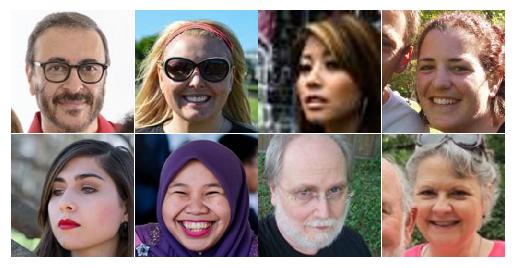

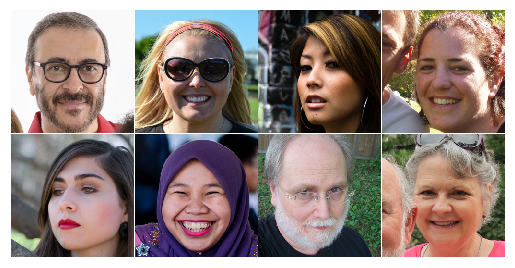

In [3]:
from PIL import Image

class RawDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        import os
        self.filenames = sorted([s.split('.')[0] for s in os.listdir('00000/256')])
        if dataset == 'train':
            self.filenames = self.filenames[:800]
        if dataset == 'test':
            self.filenames = self.filenames[800:]
        self.n = len(self.filenames)

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        f = self.filenames[i]
        f0 = f"00000/lowres/{f}.jpg"
        f1 = f"00000/256/{f}.png"
        v0 = np.array(Image.open(f0).convert("RGB").resize((256, 256)), dtype=np.float32) / 255.0
        v1 = np.array(Image.open(f1).convert("RGB"), dtype=np.float32) / 255.0
        return (
            np.transpose(v0, (2, 0, 1)),
            np.transpose(v1, (2, 0, 1))
        )


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset('train'),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return nn.Conv2d(nin, nout, 3, padding=1)

def relu(x):
    return F.relu(x, inplace=True)


class ResidualBlock(nn.Module):
    def __init__(self, n):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3(n, n)
        self.conv2 = conv3(n, n)
    
    def forward(self, x):
        return self.conv2(relu(self.conv1(x))) + x


class Model(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hidden, n_residual):
        super(Model, self).__init__()

        self.conv_i = conv3(n_in, n_hidden)
        self.residual = nn.Sequential(
            *[ResidualBlock(n_hidden) for _ in range(n_residual)]
        )
        self.conv_m = conv3(n_hidden, n_hidden)
        self.conv_o = conv3(n_hidden, n_out)
    
    def forward(self, x):
        # noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=device)
        # x_n = torch.concatenate((x, noise), axis=1)
        x_n = x + 0.1 * torch.randn_like(x)
        x_i = relu(self.conv_i(x_n))
        x_r = self.residual(x_i)
        x_m = self.conv_m(x_r)+x_i
        x_o = self.conv_o(x_m)
        # return torch.sigmoid(x_o)
        # return x_o + x
        return x_o


model = Model(3, 3, 24, 12).to(device)
print(model)
x = torch.randn((8, 3, 256, 256), device=device)
with torch.no_grad():
    y = model(x)
print(y.shape)


Model(
  (conv_i): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResidualBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ResidualBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ResidualBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): ResidualBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Co

In [5]:
def conv3s2(nin, nout):
    return nn.Conv2d(nin, nout, 3, stride=2, padding=1)

class Discriminator(torch.nn.Module):
    def __init__(self, n_in, n_hidden):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            conv3(n_in, n_hidden),
            nn.LeakyReLU(),
            conv3s2(n_hidden, n_hidden),  # 1 -> 1/2
            nn.BatchNorm2d(n_hidden),
            nn.LeakyReLU(),
            conv3(n_hidden, 2*n_hidden),
            nn.BatchNorm2d(2*n_hidden),
            nn.LeakyReLU(),
            conv3s2(2*n_hidden, 2*n_hidden),  # 1/2 -> 1/4
            nn.BatchNorm2d(2*n_hidden),
            nn.LeakyReLU(),
            conv3(2*n_hidden, 4*n_hidden),
            nn.BatchNorm2d(4*n_hidden),
            nn.LeakyReLU(),
            conv3s2(4*n_hidden, 4*n_hidden),  # 1/4 -> 1/8
            nn.BatchNorm2d(4*n_hidden),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(64*n_hidden, 32*n_hidden),
            nn.LeakyReLU(),
            nn.Linear(32*n_hidden, 1),
        )

    def forward(self, x):
        return self.main(x)


discriminator = Discriminator(3, 8).to(device)
print(discriminator)
x = torch.randn((6, 3, 256, 256), device=device)
with torch.no_grad():
    y = discriminator(x)
print(y.shape)
print(y)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Conv2d(32, 32, kernel_si

In [6]:
class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_t, lambda_c):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a  # adversarial
        self.lambda_p = lambda_p  # pixel loss
        self.lambda_f = lambda_f  # feature loss (perceptual)
        self.lambda_t = lambda_t  # texture matching loss
        self.lambda_c = lambda_c  # correct color shift caused by GAN

        # loss function for GAN
        self.bce = torch.nn.BCEWithLogitsLoss()

        # VGG16 model for feature loss
        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
        # first layer
        self.feature_extractor = vgg16.features[:4].to(device)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_1 = lambda x: self.feature_extractor((x-vgg_mean)/vgg_std)
        # print(self.feature_extractor)
        # second layer, after first layer
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        # print(self.feature_extractor_2)
            
    @staticmethod
    def gram(x):
        # g = torch.einsum('kaij,kbij->kab', x, x)
        x1 = x.reshape((x.shape[0], x.shape[1], -1))
        g = torch.matmul(x1, x1.transpose(2, 1))
        return g / (x.shape[2]*x.shape[3])
    
    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # normalization parameters
        normalize_l2 = 1.0 / 0.05  # change this to estimated L1 loss
        normalize_l2_vgg = normalize_l2 * 0.225
        normalize_l2_vgg_gram = normalize_l2_vgg ** 2

        # adversarial Loss
        if is_discriminator:
            return self.bce(discriminator_output, target)
        loss_a = -torch.mean(discriminator_output)

        # pixel loss (L1+L2)
        loss_p2 = torch.mean((generated-target)**2) * normalize_l2
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # feature loss (L1+L2)
        gen_features = self.feature_extractor_1(generated)
        tgt_features = self.feature_extractor_1(target)
        loss_f1l2 = torch.mean((gen_features-tgt_features)**2) * normalize_l2_vgg
        loss_f1l1 = torch.mean(torch.abs(gen_features-tgt_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        tgt_features_2 = self.feature_extractor_2(tgt_features)
        loss_f2l2 = torch.mean((gen_features_2-tgt_features_2)**2) * normalize_l2_vgg
        loss_f2l1 = torch.mean(torch.abs(gen_features_2-tgt_features_2))
        loss_f = 0.25*(loss_f1l2+loss_f1l1+loss_f2l2+loss_f2l1)

        # texture loss
        loss_t1 = torch.mean(self.gram(gen_features)-self.gram(tgt_features))**2
        loss_t2 = torch.mean(self.gram(gen_features_2)-self.gram(tgt_features_2))**2
        loss_t = (0.5*(loss_t1+loss_t2))**0.5 * normalize_l2_vgg_gram

        # color correction loss
        loss_c = torch.mean(torch.mean(target-generated, axis=(2, 3))**2) / normalize_l2

        # Composite loss
        total_loss = \
            self.lambda_a * loss_a + \
            self.lambda_p * loss_p + \
            self.lambda_f * loss_f + \
            self.lambda_t * loss_t + \
            self.lambda_c * loss_c
        # print(loss_a.item(), loss_p.item(), loss_f.item(), loss_t.item(), loss_c.item())

        return total_loss


lossfun = CombinedLoss(0.5, 0.5, 1.0, 0.4, 4.0)
# lossfun = CombinedLoss(0.2, 0.0, 0.0, 0.4, 0.0)
print(lossfun)
img1 = torch.randn((8, 3, 256, 256), device=device)
img2 = img1 + 0.05 * torch.randn_like(img1)
lossfun(img1, img2, discriminator(img1), False)

CombinedLoss(
  (bce): BCEWithLogitsLoss()
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (feature_extractor_2): Sequential(
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
  )
)


tensor(2.6415, device='cuda:0', grad_fn=<AddBackward0>)

In [6]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10, min_lr=0.0, verbose=True)

optimizer_d = torch.optim.Adam(
    discriminator.parameters(),
    lr = 0.0005
)

discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

/home/harry7557558/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


8 g 8.142879486083984 d 1.1772818565368652
16 g 7.451533317565918 d 0.7508410215377808
24 g 7.339890480041504 d 0.9946162104606628
32 g 7.223411560058594 d 0.712963342666626
40 g 8.992315292358398 d 1.2109038829803467
48 g 7.755471706390381 d 0.5041674971580505
56 g 8.484641075134277 d 0.4746410548686981
64 g 7.613218784332275 d 0.5007730722427368
72 g 9.219454765319824 d 0.30019089579582214
80 g 7.721421718597412 d 0.8963896036148071
88 g 8.814208030700684 d 0.41224250197410583
96 g 9.139434814453125 d 0.4499119520187378
8 g 5.5529375076293945 d 1.7569636106491089
16 g 6.476712703704834 d 1.0807583332061768
24 g 7.102226257324219 d 1.9524935483932495
Train loss: 8.193568229675293
Test loss: 6.643709659576416


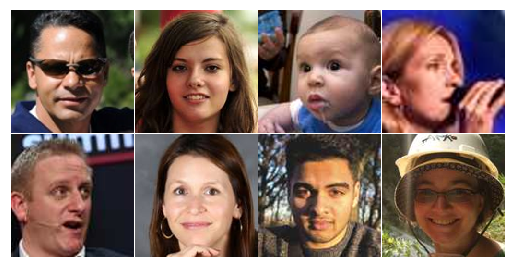

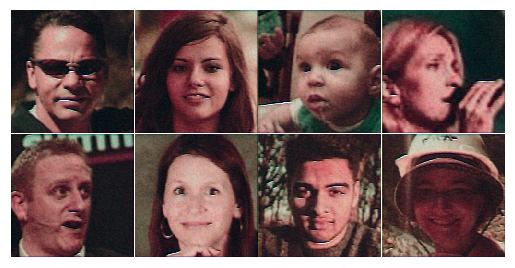

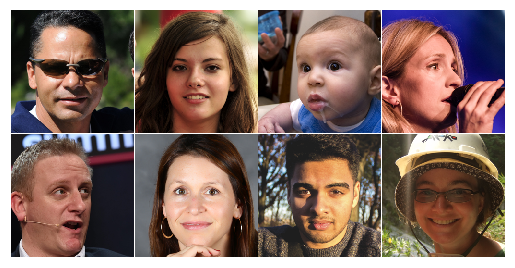

8 g 6.8670878410339355 d 0.5154410004615784
16 g 6.497465133666992 d 1.2898640632629395
24 g 6.406272888183594 d 1.2338093519210815
32 g 6.50945520401001 d 1.5675501823425293
40 g 7.354092121124268 d 1.5485942363739014
48 g 6.053457260131836 d 0.9764074087142944
56 g 6.16544246673584 d 1.1248939037322998
64 g 8.821534156799316 d 1.4771281480789185
72 g 7.374541282653809 d 0.9778776168823242
80 g 8.416912078857422 d 0.8312677145004272
88 g 7.6143999099731445 d 1.0279099941253662
96 g 7.290648460388184 d 1.5795940160751343
8 g 6.590455532073975 d 0.8975054025650024
16 g 8.223219871520996 d 1.232424259185791
24 g 6.906291484832764 d 0.8714852333068848
Train loss: 6.808042526245117
Test loss: 7.073381423950195


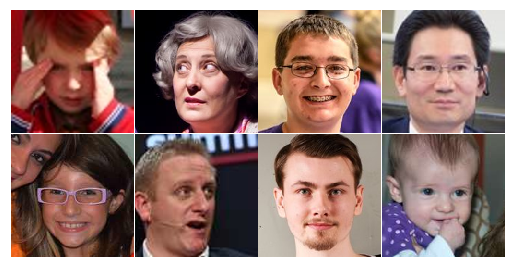

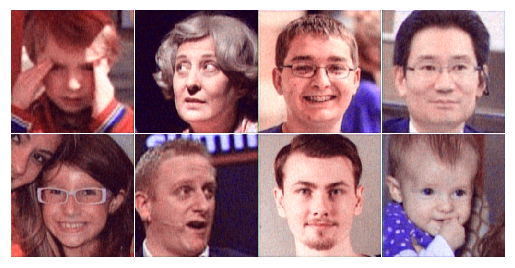

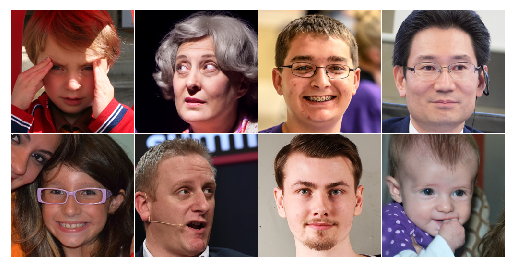

8 g 5.684937477111816 d 1.372653841972351
16 g 6.510203838348389 d 1.4103955030441284
24 g 6.0597310066223145 d 0.553093433380127
32 g 8.150498390197754 d 0.6440621614456177
40 g 7.676228046417236 d 0.5591623187065125
48 g 6.132833003997803 d 0.9171901941299438
56 g 7.0030364990234375 d 1.418473243713379
64 g 5.241297721862793 d 1.0206042528152466
72 g 6.202530384063721 d 1.4008591175079346
80 g 6.015961647033691 d 0.9540805816650391
88 g 6.451186656951904 d 0.9693862199783325
96 g 6.305055141448975 d 1.174511432647705
8 g 5.307791709899902 d 1.1869505643844604
16 g 7.902736663818359 d 0.9353431463241577
24 g 8.57616138458252 d 0.879393458366394
Train loss: 6.699589729309082
Test loss: 7.021182537078857


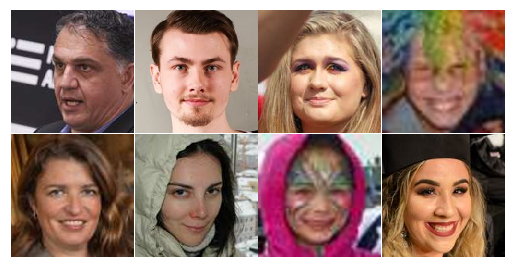

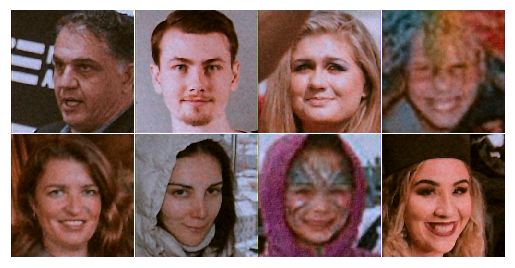

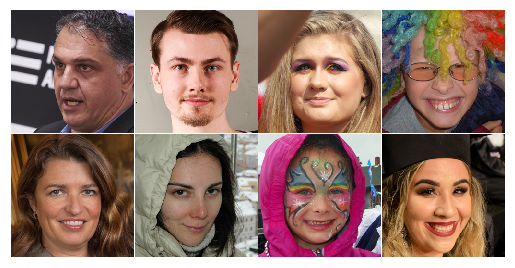

8 g 8.049951553344727 d 1.1231913566589355
16 g 6.575161457061768 d 1.0104851722717285
24 g 7.9334564208984375 d 1.209603190422058
32 g 6.614748001098633 d 1.5039479732513428
40 g 6.0139241218566895 d 1.0198568105697632
48 g 4.91408109664917 d 1.5391972064971924
56 g 5.599745273590088 d 1.2663426399230957
64 g 7.456356525421143 d 1.1127218008041382
72 g 6.992412567138672 d 0.9228314161300659
80 g 6.440979957580566 d 1.2769029140472412
88 g 5.821287631988525 d 0.7856316566467285
96 g 6.591598987579346 d 1.2828052043914795
8 g 5.209627628326416 d 1.3562135696411133
16 g 5.350081443786621 d 1.3787047863006592
24 g 6.472257137298584 d 1.377079725265503
Train loss: 6.107917308807373
Test loss: 5.942592144012451


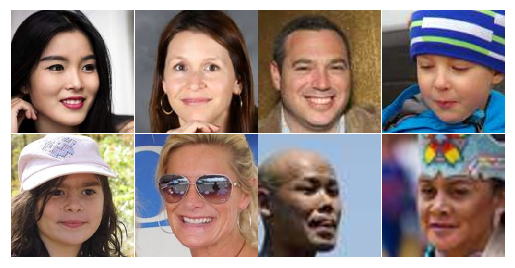

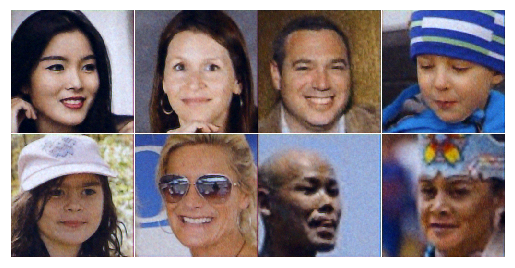

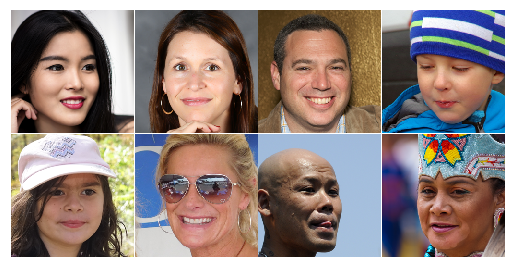

8 g 6.096018314361572 d 1.229556679725647
16 g 5.777389049530029 d 1.4216915369033813
24 g 5.779738903045654 d 1.4476547241210938
32 g 5.256612300872803 d 1.1431517601013184
40 g 4.658090591430664 d 1.5204367637634277
48 g 6.028865814208984 d 1.3885219097137451
56 g 5.959652423858643 d 1.1483042240142822
64 g 5.338142395019531 d 1.273490071296692
72 g 5.364058971405029 d 0.9218538403511047
80 g 4.909059524536133 d 1.142435073852539
88 g 4.776087760925293 d 1.5225414037704468
96 g 4.733489036560059 d 1.198662281036377
8 g 5.42020845413208 d 0.9454155564308167
16 g 5.03489875793457 d 0.9089736938476562
24 g 6.671300411224365 d 0.7404327988624573
Train loss: 5.678131580352783
Test loss: 5.725777626037598


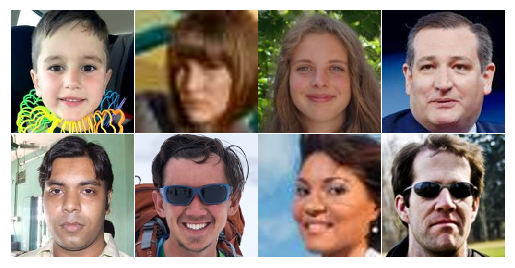

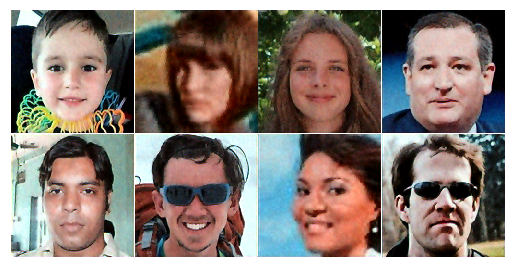

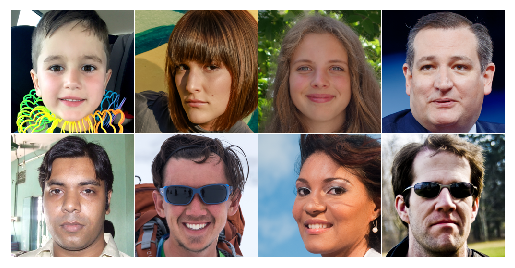

8 g 5.5152974128723145 d 0.9248500466346741
16 g 5.910380840301514 d 1.023971676826477
24 g 5.630746841430664 d 1.5935897827148438
32 g 6.2037835121154785 d 1.1741306781768799
40 g 6.727532863616943 d 1.1877951622009277
48 g 5.6921305656433105 d 1.3233144283294678
56 g 4.470587253570557 d 1.256656289100647
64 g 6.171109199523926 d 0.985209047794342
72 g 5.677526950836182 d 1.2367585897445679
80 g 5.374250411987305 d 1.212699294090271
88 g 3.6289074420928955 d 1.1512677669525146
96 g 4.854974746704102 d 1.2674355506896973
8 g 5.658702373504639 d 1.3908425569534302
16 g 6.761735916137695 d 1.0450685024261475
24 g 5.968735694885254 d 1.4583202600479126
Train loss: 5.744439125061035
Test loss: 6.225042819976807


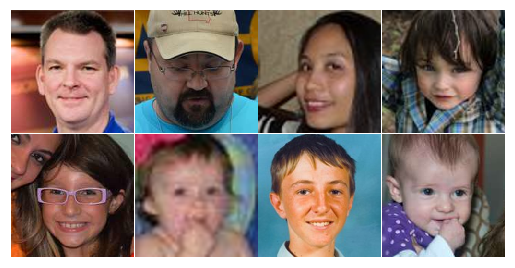

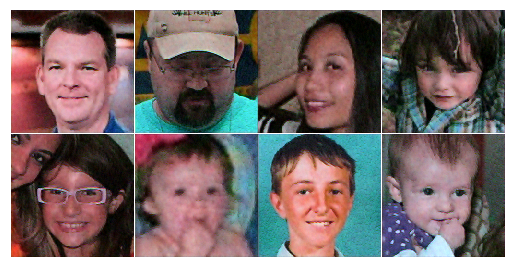

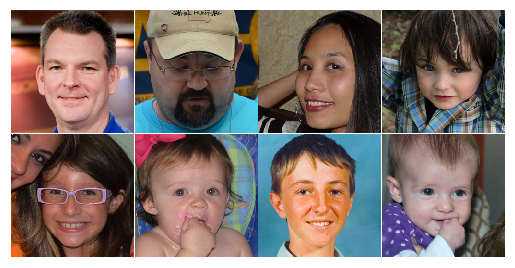

8 g 6.829237461090088 d 0.9235715866088867
16 g 5.383631229400635 d 0.8350034952163696
24 g 5.39637565612793 d 1.1335561275482178
32 g 6.196231842041016 d 0.9151374101638794
40 g 5.069797992706299 d 0.8279829025268555
48 g 5.351985931396484 d 0.6759294271469116
56 g 6.373476982116699 d 0.8328064680099487
64 g 6.084806442260742 d 0.7498838901519775
72 g 5.987961769104004 d 0.9518733620643616
80 g 6.148239612579346 d 1.5605827569961548
88 g 6.885590076446533 d 0.6022820472717285
96 g 6.5563836097717285 d 0.9669036865234375
8 g 5.921767234802246 d 0.9984185099601746
16 g 5.847902774810791 d 1.130980372428894
24 g 6.401339530944824 d 0.7580276727676392
Train loss: 5.891387939453125
Test loss: 5.92933464050293


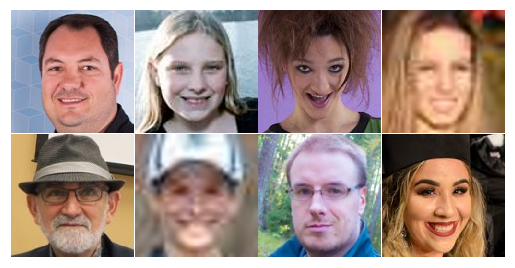

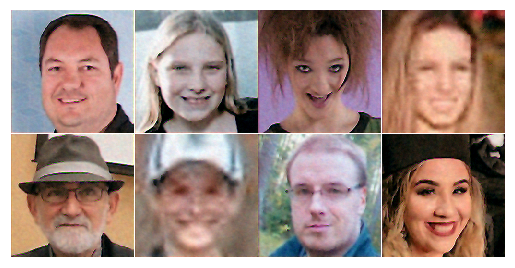

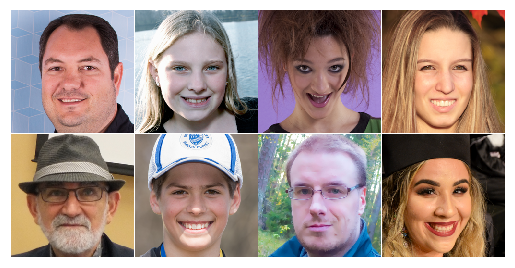

8 g 6.969681262969971 d 0.6457831859588623
16 g 6.143229007720947 d 0.7611896991729736
24 g 5.0470170974731445 d 1.235703468322754
32 g 5.594356060028076 d 0.7551963329315186
40 g 6.748764514923096 d 0.8630925416946411
48 g 7.107949733734131 d 0.8183664083480835
56 g 6.525504112243652 d 1.198573350906372
64 g 6.557971000671387 d 2.4278697967529297
72 g 7.116452693939209 d 1.5072931051254272
80 g 7.099658489227295 d 0.5033025145530701
88 g 6.325717449188232 d 0.7760465741157532
96 g 6.357108116149902 d 0.44724515080451965
8 g 6.165569305419922 d 0.818035900592804
16 g 9.145164489746094 d 0.6417799592018127
24 g 5.684767723083496 d 1.2432297468185425


KeyboardInterrupt: 

In [7]:
def train_epoch(dataloader, test=False):
    total_loss = None
    batch_count = 0
    
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        real_labels = torch.ones(x.shape[0], 1).to(device)
        fake_labels = torch.zeros(x.shape[0], 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        if not test:
            optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        if not test:
            optimizer.step()

        if total_loss is None:
            total_loss = g_loss
        else:
            total_loss += g_loss
        batch_count += 1

        if batch_count % 8 == 0:
            print(batch_count, 'g', g_loss.item(), 'd', d_loss.item())
    
    return total_loss / batch_count, (x, fake_images.detach(), y)


batch_size = 8

for epoch in range(10000):
    trainloader = torch.utils.data.DataLoader(
        RawDataset('train'), batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(
        RawDataset('test'), batch_size=8, shuffle=True)
    
    train_loss, _ = train_epoch(trainloader)
    test_loss, _ = train_epoch(testloader, test=True)

    model_g_path = "model02_g.pth"
    model_d_path = "model02_d.pth"
    torch.save(model, model_g_path)
    torch.save(discriminator, model_d_path)

    print("Train loss:", train_loss.item())
    print("Test loss:", test_loss.item())
    scheduler.step(test_loss)
    if optimizer.param_groups[0]['lr'] < 1e-4:
        break

    if epoch % 1 == 0:
        plot_imgs(_[0])
        plot_imgs(_[1])
        plot_imgs(_[2])
